---
title: "Graph Diffusion"
date: 2022-07-25T00:00:00-00:00
math: true
---
{{< math.inline >}}
{{ if or .Page.Params.math .Site.Params.math }}

<!-- KaTeX -->
<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/katex@0.11.1/dist/katex.min.css" integrity="sha384-zB1R0rpPzHqg7Kpt0Aljp8JPLqbXI3bhnPWROx27a9N0Ll6ZP/+DiW/UqRcLbRjq" crossorigin="anonymous">
<script defer src="https://cdn.jsdelivr.net/npm/katex@0.11.1/dist/katex.min.js" integrity="sha384-y23I5Q6l+B6vatafAwxRu/0oK/79VlbSz7Q9aiSZUvyWYIYsd+qj+o24G5ZU2zJz" crossorigin="anonymous"></script>
<script defer src="https://cdn.jsdelivr.net/npm/katex@0.11.1/dist/contrib/auto-render.min.js" integrity="sha384-kWPLUVMOks5AQFrykwIup5lo0m3iMkkHrD0uJ4H5cjeGihAutqP0yW0J6dpFiVkI" crossorigin="anonymous" onload="renderMathInElement(document.body);"></script>

<script>
    document.addEventListener("DOMContentLoaded", function() {
        renderMathInElement(document.body, {
            delimiters: [
                {left: "$$", right: "$$", display: true},
                {left: "$", right: "$", display: false}
            ]
        });
    });
</script>

{{ end }}
{{</ math.inline >}}

# Graph Diffusion
This is taken from [Diffusion Convolutional Neural Networks](https://arxiv.org/pdf/1511.02136v6.pdf) (referenced in the footer). According to the authors, a **diffusion convolution** scans a diffusion process across each node. Analog to biology, where the information is allowed to propagate conditional of its density and environment.

It was applied to node classification, edge classification and graph classification, but node-classification is the task I wanted to focus on. When first presented, it was a novel way to effectively apply convolutions (invariant to location and rotation), to arbitrarily-structured data (i.e. graphs). Based on the results presented, the DCNN model outperformed a probabilistic-relational model in citation (a *conditional-random field*, no I do not know much about that) in graph topic-classification. 

Diffusion outperforms probabilistic relational methods, is flesible  to handle graphs with node features, edge features and purely structural information, is polynomial-time, model only has $H/times F$ parameters (H is num hops, F is num features), completed with a dense layer connecting $Z$ to the conditional prediction


Main point in the paper was using a novel way to propagate the features throughout the graph structure

In [171]:
import networkx as nx
import tensorflow as tf
import numpy as np

# Simple Example

This is getting more intimate with Graph Diffusion, since the term seemed a bit hand-wavy (especially as the authors define it by quoting as a "diffusion mechanism"):

>  *"Briefly, rather than scanning a ‘square’ of parameters across a grid-structured input like the standard convolution operation, the diffusion-convolution operation builds a latent representation by scanning a diffusion process across each node in a graph-structured input"*

A.shape=(5, 5), X.shape=(5, 2), Y.shape=(5, 2)


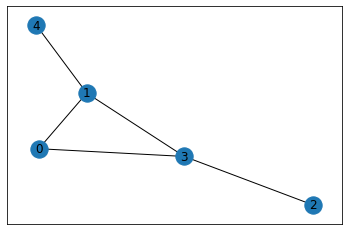

In [99]:
# define a simple adjacency matrix
A = np.matrix('''
    0 1 0 1 0;
    1 0 0 1 1;
    0 0 0 1 0;
    1 1 1 0 0;
    0 1 0 0 0
''')

# feature matrix
X = np.matrix('''
    2 0;
    0 4;
    3 1;
    5 6;
    9 3
''')


# labels 
Y = np.matrix('''
    0 1;
    1 0; 
    1 0;
    1 0;
    0 1
''')

print(f'{A.shape=}, {X.shape=}, {Y.shape=}')

# just for plotting
G = nx.from_numpy_matrix(A)
nx.draw_networkx(G, with_labels=True)

The diffusion kernel is given by:
$$
[A^{0}, A^{1},...,A^{k-1}]
$$

where $A$ is the adjacency matrix, and $k$ is the number of 1-hops. Normalizing the adjacency matrix is achived by dividing by the degree matrix $D$ at each stage, so it ends up being:

$$
A^{i+1} = \frac{A}{d}\times A^{i}
$$

Experimenting with $k=2$ hops, so the first dimension of $K$ would be $3$ if self-loops are included.

In [100]:
k = 2 # num-hops
K = [np.identity(A.shape[0])]

d = A.sum(0)

K.append(A / (d+1.0))
for i in range(2, k+1):
    K.append(
        np.dot(A/(d+1.0), K[-1])
    )

K = np.array(K, dtype=np.float32) # at this point, shape is [k+1, num_nodes, num_nodes]
K = np.transpose(K, (1, 0, 2)) # here it becomes (num_nodes, k+1, num_nodes)


K.shape

(5, 3, 5)

Indexes diffusion kernel for node one, here's how to read it:

$i^{th}$ index is number of hops  
$j^{th}$ index is to which node  

So the probability of jumping to node 1 in 1 hop 0.25 (zero-indexed), whilst probabilities for all nodes in $0$ hops are $0$ for obvious reasons


In [101]:
K[0] 

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.25      , 0.        , 0.25      , 0.        ],
       [0.16666667, 0.0625    , 0.125     , 0.0625    , 0.125     ]],
      dtype=float32)

Once the diffusion kernel is defined, the next step was to weight the product of the diffusion kernel with node features using a weight matrix:  

$$
Z = f(W^c\odot P^*X)
$$

$W$ is a weight matrix, let $P^*X$ be $PX$  
The product of the following is indexed as follows:  
- $i^{th}$ indexes an individual node  
- $j^{th}$ is number of hops  
- $k^{th}$ is feature (I think)

PX captures the probability of hopping, hence allows the features to propagate conditional to their $k$-hop distance to neighbours  

In [102]:
K, X # K is kernel, X is features

(array([[[1.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.25      , 0.        , 0.25      , 0.        ],
         [0.16666667, 0.0625    , 0.125     , 0.0625    , 0.125     ]],
 
        [[0.        , 1.        , 0.        , 0.        , 0.        ],
         [0.33333334, 0.        , 0.        , 0.25      , 0.5       ],
         [0.08333334, 0.27083334, 0.125     , 0.08333334, 0.        ]],
 
        [[0.        , 0.        , 1.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.25      , 0.        ],
         [0.08333334, 0.0625    , 0.125     , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , 1.        , 0.        ],
         [0.33333334, 0.25      , 0.5       , 0.        , 0.        ],
         [0.08333334, 0.08333334, 0.        , 0.27083334, 0.125     ]],
 
        [[0.        , 0.        , 0.        , 0.        , 1.        ],
         [0.        , 0.25      , 0.        , 0.        , 0.     

In [103]:
PX = np.einsum('ijk,kl->ijl', K, X) # same as tf.matmul(K, X)
PX, PX.shape

(array([[[2.        , 0.        ],
         [1.25      , 2.5       ],
         [2.14583334, 1.125     ]],
 
        [[0.        , 4.        ],
         [6.41666669, 3.        ],
         [0.95833335, 1.70833339]],
 
        [[3.        , 1.        ],
         [1.25      , 1.5       ],
         [0.54166667, 0.375     ]],
 
        [[5.        , 6.        ],
         [2.16666669, 1.5       ],
         [2.64583339, 2.3333334 ]],
 
        [[9.        , 3.        ],
         [0.        , 1.        ],
         [1.60416667, 0.75      ]]]),
 (5, 3, 2))

In [104]:
PX[1]

array([[0.        , 4.        ],
       [6.41666669, 3.        ],
       [0.95833335, 1.70833339]])

$K$ = 
```
        [[[1.        , 0.        , 0.        , 0.        , 0.        ],
Hop 1 -> [0.        , 0.25      , 0.        , 0.25      , 0.        ],
         [0.16666667, 0.0625    , 0.125     , 0.0625    , 0.125     ]],
 
        [[0.        , 1.        , 0.        , 0.        , 0.        ],
         [0.33333334, 0.        , 0.        , 0.25      , 0.5       ],
         [0.08333334, 0.27083334, 0.125     , 0.08333334, 0.        ]],
 
        [[0.        , 0.        , 1.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 0.25      , 0.        ],
         [0.08333334, 0.0625    , 0.125     , 0.        , 0.        ]],
 
        [[0.        , 0.        , 0.        , 1.        , 0.        ],
         [0.33333334, 0.25      , 0.5       , 0.        , 0.        ],
         [0.08333334, 0.08333334, 0.        , 0.27083334, 0.125     ]],
 
        [[0.        , 0.        , 0.        , 0.        , 1.        ],
         [0.        , 0.25      , 0.        , 0.        , 0.        ],
         [0.08333334, 0.        , 0.        , 0.0625    , 0.125     ]]]
```

$X$ = 
```
        [[2, 0],
        [0, 4],
        [3, 1],
        [5, 6],
        [9, 3]]
```

For node $0$, hop $1$, feature $1$, we take $K[0, 1]$ times $X[0, 1]$: 

This is less-optimized, but more index-friendly of rewriting the equation prior
$$
Z_{ijk} = f\left(W^{c}_{jk}\cdot\sum_{l=1}^{N} P_{ijl}X_{lk}\right)
$$

$N$ is number of nodes

trying $(i=1, j=1, k=0)$, which should result in $PX[1, 1, 0]$

In [95]:
K[1, 1, :], X[:, 0]

(array([0.33333334, 0.        , 0.        , 0.25      , 0.5       ],
       dtype=float32),
 matrix([[0],
         [4],
         [1],
         [6],
         [3]]))

In [108]:
K[0, 1, 1] * X[:, 1]

matrix([[0.  ],
        [1.  ],
        [0.25],
        [1.5 ],
        [0.75]])

In [109]:
np.sum(K[1, 1, :] * X[:, 0]) # It works! It's equal to PX[1, 1 ,0]

6.416666686534882

In [110]:
PX[1,1,0]

6.416666686534882

Past this point, $Z$ is weighted once again using another set of weights and then subject to a nonlinear activation function, standard layers implemented by `keras` layers and hence less intellectually stimulating at first glance. I may return to this paper from a purely philosophical standpoint, but the previous notes cover the parts of Tensor calculus that confused me the most.

For interested readers, I suggest the paper linked

## References  
[Atwood, J., & Towsley, D. (2016). Diffusion-convolutional neural networks. Advances in neural information processing systems, 29](https://arxiv.org/pdf/1511.02136v6.pdf)